In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import veros.core.density.nonlinear_eq2 as neq2
from matplotlib import colors
import plotting_function_avg as pltfunc
import diagnostic_function as diagf
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import glob



Importing core modules
 Using computational backend numpy on cpu
 Runtime settings are now locked



In [3]:
def depth_long_two_fields(field, field_color_name, field_lines_name, span, norm='Normalize', levels = 31, labeled_levels = [-5000], cmap = "cmo.balance", neg_pos = False, figsize=(8, 4) ):
    vmin, vmax = span
    linestyle_neg = 'solid'
    if neg_pos :
        linestyle_neg = 'dashed'
        
    if norm=='Normalize':
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    elif norm=='TwoSlopeNorm':
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 0.04])

    ax = fig.add_subplot(gs[0])
    contour = field_color_name.plot.contourf(ax=ax, levels=levels, norm=norm, cmap=cmap, add_colorbar=False)
    
    field_color_name.where(field_color_name > 0).plot.contour(ax=ax, norm=norm, levels=levels, colors='k', linestyles='solid', alpha=0.15)
    field_color_name.where(field_color_name <= 0).plot.contour(ax=ax, norm=norm, levels=levels, colors='k', linestyles=linestyle_neg, alpha=0.1)
    
    labeled_contour_lines = field_lines_name.plot.contour(ax=ax, levels=labeled_levels, colors='k', linestyles=linestyle_neg, alpha=0.5)
    ax.clabel(labeled_contour_lines, levels=labeled_levels, fmt="%.2f", inline=True, fontsize=8, colors="black")
    ax.set_title(field +  rf", Time = {field_color_name.years.values:.0f}y")
    #ax.set_xlim(-70,0)

    cax_t = fig.add_subplot(gs[1])  
    fig.colorbar(contour, cax=cax_t, orientation='vertical')
    #cax_t.set_title(field)

    plt.tight_layout()
    
def axis_depth_long_two_fields(axis, field, field_color_name, field_lines_name, span, norm='Normalize', levels = 31, labeled_levels = [-5000], cmap = "cmo.balance", neg_pos = False, alpha_lines=0.5):
    vmin, vmax = span
    linestyle_neg = 'solid'
    if neg_pos :
        linestyle_neg = 'dashed'
        
    if norm=='Normalize':
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    elif norm=='TwoSlopeNorm':
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    contour = field_color_name.plot.contourf(ax=axis, levels=levels, norm=norm, cmap=cmap, add_colorbar=False)
    
    field_color_name.where(field_color_name > 0).plot.contour(ax=axis, norm=norm, levels=levels, colors='k', linestyles='solid', alpha=0.15)
    field_color_name.where(field_color_name <= 0).plot.contour(ax=axis, norm=norm, levels=levels, colors='k', linestyles=linestyle_neg, alpha=0.1)
    
    labeled_contour_lines_neg = field_lines_name.where(field_lines_name <= 0).plot.contour(ax=axis, levels=labeled_levels, colors='k', linestyles=linestyle_neg, alpha=alpha_lines)
    axis.clabel(labeled_contour_lines_neg, levels=labeled_levels, fmt="%.2f", inline=True, fontsize=8, colors="black")
    labeled_contour_lines_pos = field_lines_name.where(field_lines_name > 0).plot.contour(ax=axis, levels=labeled_levels, colors='k', linestyles='solid', alpha = alpha_lines)
    axis.clabel(labeled_contour_lines_pos, levels=labeled_levels, fmt="%.2f", inline=True, fontsize=8, colors="black")
    axis.set_title(field + rf' - {field_color_name.years:.0f}y') 
    #ax.set_xlim(-70,0)

    return contour

In [13]:
Exp = "Long_SO/Long_SO_suite_2"

In [14]:
dir_name = "/home/x_titmo/work/runs_output/NW2_clim/" + Exp
#dir_name = "/home/x_titmo/work/runs_output/NW2_clim/" + "REF_ter"

ds_avg =xr.open_mfdataset(dir_name + "/nw2_dino.0004.averages.nc", decode_times=False)
ds_ovr =xr.open_mfdataset(dir_name + "/nw2_dino.0004.overturning.nc", decode_times=False)
ds_snap =xr.open_dataset(dir_name  + "/nw2_dino.0004.snapshot.nc", decode_times=False)

In [15]:
# dir_name = "/home/x_titmo/work/runs_output/NW2_clim/" + "Dino_clim_bis/"
# #dir_name = "/home/x_titmo/work/runs_output/NW2_clim/" + "REF_ter"

# ds_avg =xr.open_mfdataset(dir_name + "/nw2_dino.0035.averages.nc", decode_times=False)
# ds_ovr =xr.open_mfdataset(dir_name + "/nw2_dino.0035.overturning.nc", decode_times=False)
# ds_snap =xr.open_dataset(dir_name  + "/nw2_dino.0035.snapshot.nc", decode_times=False)

In [16]:
ds_avg = ds_avg.assign_coords(years=("Time", (ds_avg.Time / 365).data))
ds_ovr = ds_ovr.assign_coords(years=("Time", (ds_ovr.Time / 365).data))

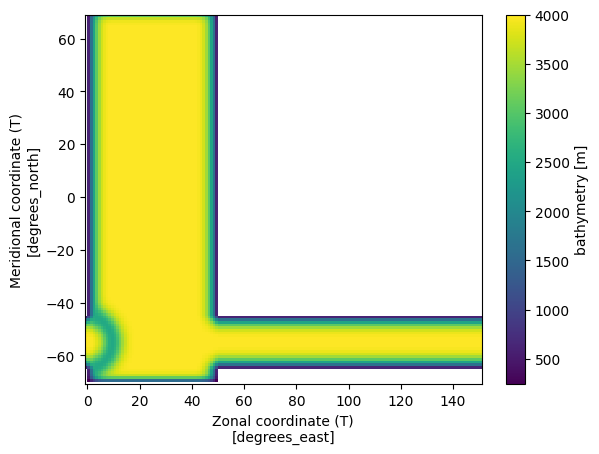

In [17]:
ds_snap.bathymetry.plot()
#plt.xlim(49,51)

In [18]:
land_mask = (ds_snap.zt.to_numpy()[:,np.newaxis, np.newaxis] <= -ds_snap.bathymetry.to_numpy()[np.newaxis,...]) | (ds_snap.salt.isel(Time=0).drop_vars("Time") == 0.0)

weight_xyz_t = (1-land_mask) * ds_snap.area_t * ds_snap.dzt
weight_xyz_t = weight_xyz_t.fillna(0) / weight_xyz_t.sum()
weights_xy_t = weight_xyz_t / weight_xyz_t.sum('xt').sum('yt')
weights_z_t = weight_xyz_t.mean(dim=('xt','yt'))

land_mask_W = xr.DataArray(land_mask.values, dims=('zw', 'yt', 'xt'), coords={'zw': ds_snap.zw, 'yt': ds_snap.yt, 'xt': ds_snap.xt})

weight_xyz_w = (1-land_mask_W) * ds_snap.area_t * ds_snap.dzw
weight_xyz_w = weight_xyz_w.fillna(0) / weight_xyz_w.sum()
weights_xy_w = weight_xyz_w / weight_xyz_w.sum('xt').sum('yt')
weights_z_w = weight_xyz_w.mean(dim=('xt','yt'))

weight_surf = ds_snap.area_t.fillna(0)
weight_surf =weight_surf/ weight_surf.sum('xt').sum('yt')

In [19]:
ytp = 1000
salinity = ds_avg.salt.sel(Time=ytp * 365, method="nearest").where(ds_avg.xt<50.)
temperature = ds_avg.temp.sel(Time=ytp * 365, method="nearest").where(ds_avg.xt<50.)

rho = neq2.nonlin2_eq_of_state_rho(salinity, temperature, -ds_snap.zt)
prho = neq2.nonlin2_eq_of_state_rho(salinity, temperature, 0) +1024.-1000.
mld = diagf.mld(prho, z_ref=0, sig_dev=0.01)
rho_avg = neq2.nonlin2_eq_of_state_rho(salinity.weighted(weight_xyz_t).mean(dim=('xt', 'yt', 'zt')), temperature.weighted(weight_xyz_t).mean(dim=('xt', 'yt', 'zt')), -ds_snap.zt) 
rho_grav=neq2.nonlin2_eq_of_state_rho(35.0, 9.85,  -ds_snap.zt)
rho_anomaly = rho - rho_avg

cond = (ds_snap.zt > -2000) & (((1-land_mask)*ds_snap.zt).min(dim='zt')<-2000)
zeta_2000, zeta_temp_2000, zeta_salt_2000 = diagf.heigth_anomaly_CoM(salinity.where(cond), 
                                                        temperature.where(cond),
                                                        salinity.where(cond).weighted(weight_xyz_t).mean(dim=("xt","yt","zt")), 
                                                        temperature.where(cond).weighted(weight_xyz_t).mean(dim=("xt","yt","zt")), 
                                                        ds_snap.zt.where(cond), 
                                                        z_v= -1000)
Nsqr_T, Nsqr_S, N_sqr = diagf.Nsqr_decomposed(temperature, ds_snap.dzt, salinity, ds_snap.zt, ds_snap.zw)
N_sqr = N_sqr.expand_dims({"years": [ytp]}).sel(years=ytp)


dict_field_zonal_mean_s = salinity.weighted(weight_xyz_t).mean(dim=('xt'))
dict_field_zonal_mean_t = temperature.weighted(weight_xyz_t).mean(dim=('xt'))
dict_field_zonal_mean_rho_anomaly = rho_anomaly.weighted(weight_xyz_t).mean(dim=('xt'))
dict_field_zonal_mean_prho = prho.weighted(weight_xyz_t).mean(dim=('xt'))
dict_field_zeta_2000 = zeta_2000.weighted(weight_xyz_t).mean(dim=('zt'))
dict_field_mld = mld
dict_field_bsf = (ds_avg.psi * 1e-6).sel(Time=ytp * 365, method="nearest")
dict_field_Nsqr = N_sqr.where(N_sqr.zw>-2000).weighted(weight_xyz_w).mean(dim=('zw'))

dict_field_moc = (ds_ovr.vsf_depth * 1e-6).sel(Time=ytp * 365, method="nearest")
dict_field_eddies = (ds_ovr.bolus_depth * 1e-6).sel(Time=ytp * 365, method="nearest")
dict_field_rmoc = -(dict_field_moc + dict_field_eddies)

labeled_lines_rho = [-2., -1.5, -1., -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labeled_lines_temp =[2, 3, 4, 5, 5.5, 6., 6.5, 7., 7.5, 8, 9, 10, 15, 20, 25]
 
#Pycnocline H=4000m, zv=-2000m (env)
z_bottom_mask = ds_snap.zt.where(ds_snap.zt > -4000).min()
mask_4000 = (ds_snap.zt >= z_bottom_mask) & (((1-land_mask)*ds_snap.zt).min(dim='zt')<= z_bottom_mask)
zmean_4000 = temperature.zt.where(mask_4000).weighted(weight_xyz_t).mean(dim=("xt","yt","zt"))
salinity_pyc = salinity.where(mask_4000)
temperature_pyc = temperature.where(mask_4000)
meridional_pic_fab_4000, zonavg_depth_anomaly_approx_4000, zonavg_mean_N2_approx_4000, H_plus_4000, H_thin_4000 = diagf.pycnocline_fab(salinity_pyc, temperature_pyc, -2*zmean_4000, ds_snap.zt, weight_surf, weight_xyz_t, land_mask)
meridional_pic_gna_4000, zonavg_numer_4000, zonavg_denum_4000  = diagf.pycnocline_gnanadesikan(salinity_pyc, temperature_pyc, -2*zmean_4000, ds_snap.zt, weight_surf, weight_xyz_t, land_mask)


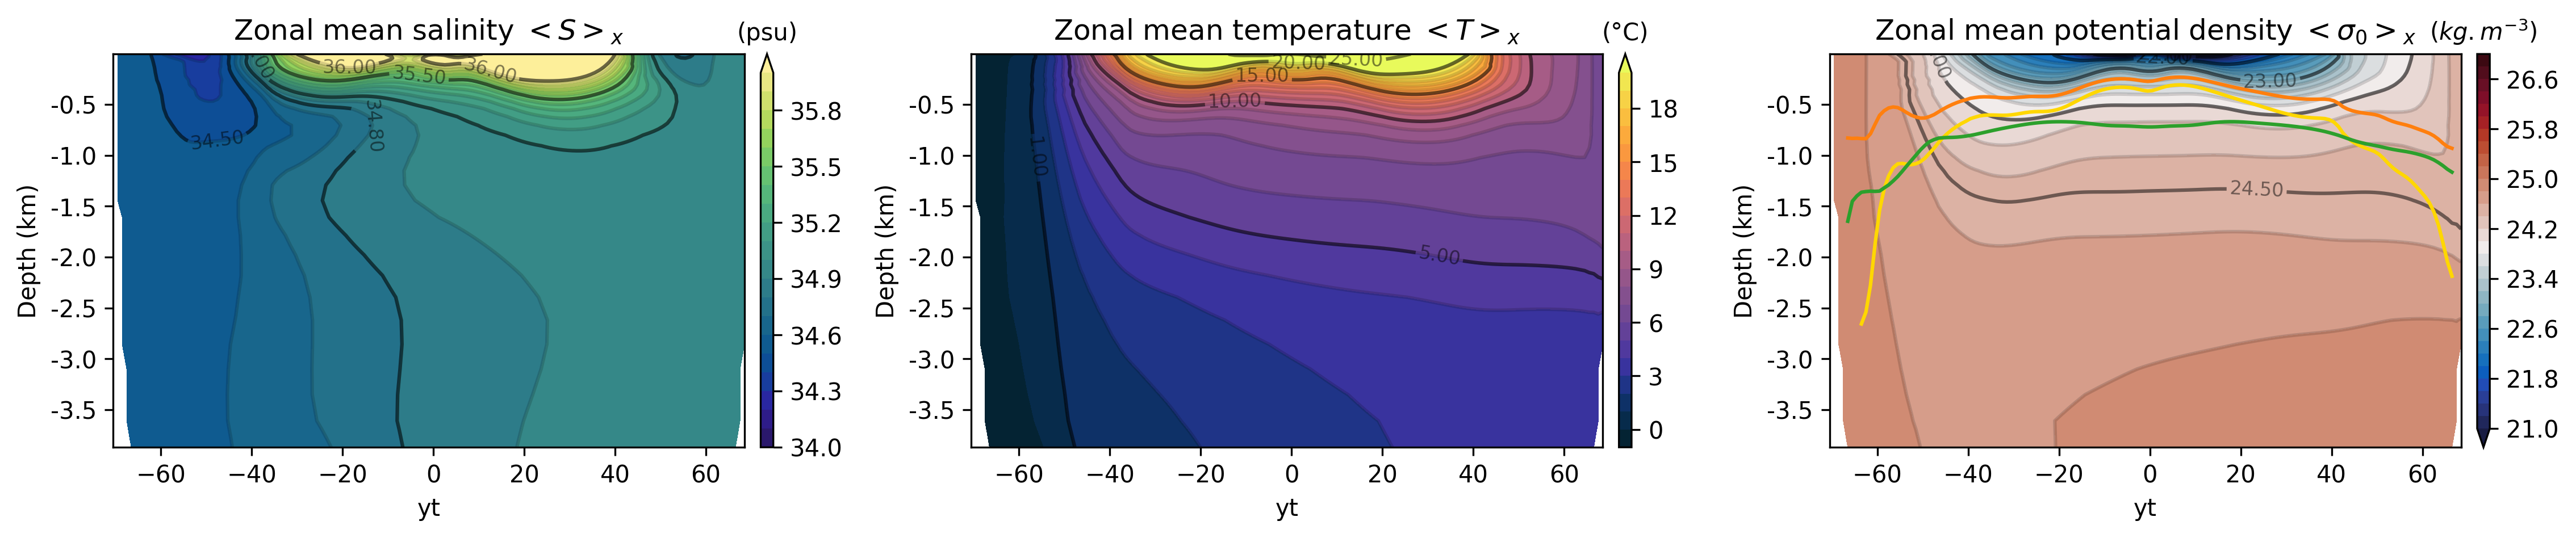

In [10]:
fig = plt.figure(figsize=(18,3), dpi=300)

gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1,1,1], height_ratios=[1], wspace=0.3, hspace = 0.5)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[1, 0.02], wspace = 0.05)
ax1 = fig.add_subplot(gs1[0,0])
cax1 = fig.add_subplot(gs1[0,1])
ax1_labeled_levels = [34.0, 34.5, 34.8, 35., 35.5, 36.,]
contour1 = axis_depth_long_two_fields(ax1, "zonal_mean_s", dict_field_zonal_mean_s, dict_field_zonal_mean_s, span = (34,36), norm='Normalize', levels = 21, labeled_levels = ax1_labeled_levels, cmap = "cmo.haline", neg_pos = False)
fig.colorbar(contour1, cax=cax1, orientation='vertical')
#cax_t.set_title(field)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=[1, 0.02], wspace = 0.05)
ax2 = fig.add_subplot(gs2[0,0])
cax2 = fig.add_subplot(gs2[0,1])
contour2 = axis_depth_long_two_fields(ax2, "zonal_mean_t", dict_field_zonal_mean_t, dict_field_zonal_mean_t, span = (-1, 20), norm='Normalize', levels = 22, labeled_levels = [1., 5., 10., 15., 20., 25., 30.], cmap="cmo.thermal")
fig.colorbar(contour2, cax=cax2, orientation='vertical')


gs3 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2], width_ratios=[1, 0.02], wspace = 0.05)
ax3 = fig.add_subplot(gs3[0,0])
cax3 = fig.add_subplot(gs3[0,1])
contour3 = axis_depth_long_two_fields(ax3, "zonal_mean_rho_anomaly", dict_field_zonal_mean_prho, dict_field_zonal_mean_prho, span = (21,27), norm='Normalize', levels = 31, labeled_levels = [21., 22., 23., 24., 24.5, 25., 26, 27.], cmap="cmo.balance")
fig.colorbar(contour3, cax=cax3, orientation='vertical')
H_thin_contour = H_thin_4000.sel(yt=slice(None, None)).plot(ax=ax3, color='tab:orange', linewidth=1.5, label=r'$H_{thin}$')
H_plus_contour = (-H_plus_4000).sel(yt=slice(-64, None)).plot(ax=ax3, color='gold', linewidth=1.5, label=r'$H_{pyc}$')
H_gna_contour = (-meridional_pic_gna_4000).sel(yt=slice(None, None)).plot(ax=ax3, color='tab:green', linewidth=1.5, label=r'$H_{gna}$')

ax_left=[ax1, ax2, ax3]
titles =[r"Zonal mean salinity $<S>_x$", r"Zonal mean temperature $<T>_x$", r"Zonal mean potential density $<\sigma_0>_x$"]
i=0
for axis in ax_left :
    axis.set_yticklabels([f"{(tick/1000):.1f}" for tick in axis.get_yticks()])
    axis.set_ylabel('Depth (km)')
    axis.set_title(titles[i])
    i+=1
caxis = [cax1, cax2, cax3]
titles_cax=['(psu)', '(°C)', r'($kg.m^{-3}$)', '(m)', r'($s^{-1}$)']
i=0
for cax in caxis : 
    cax.set_title(titles_cax[i],fontsize=10.)
    i+=1

plt.tight_layout()
path_to_plot = f"/home/x_titmo/work/analysis/NeverWorld2/plots/report/"
#plt.savefig(path_to_plot + f'Clim_1000y_TSrho.png', bbox_inches='tight')

plt.show()

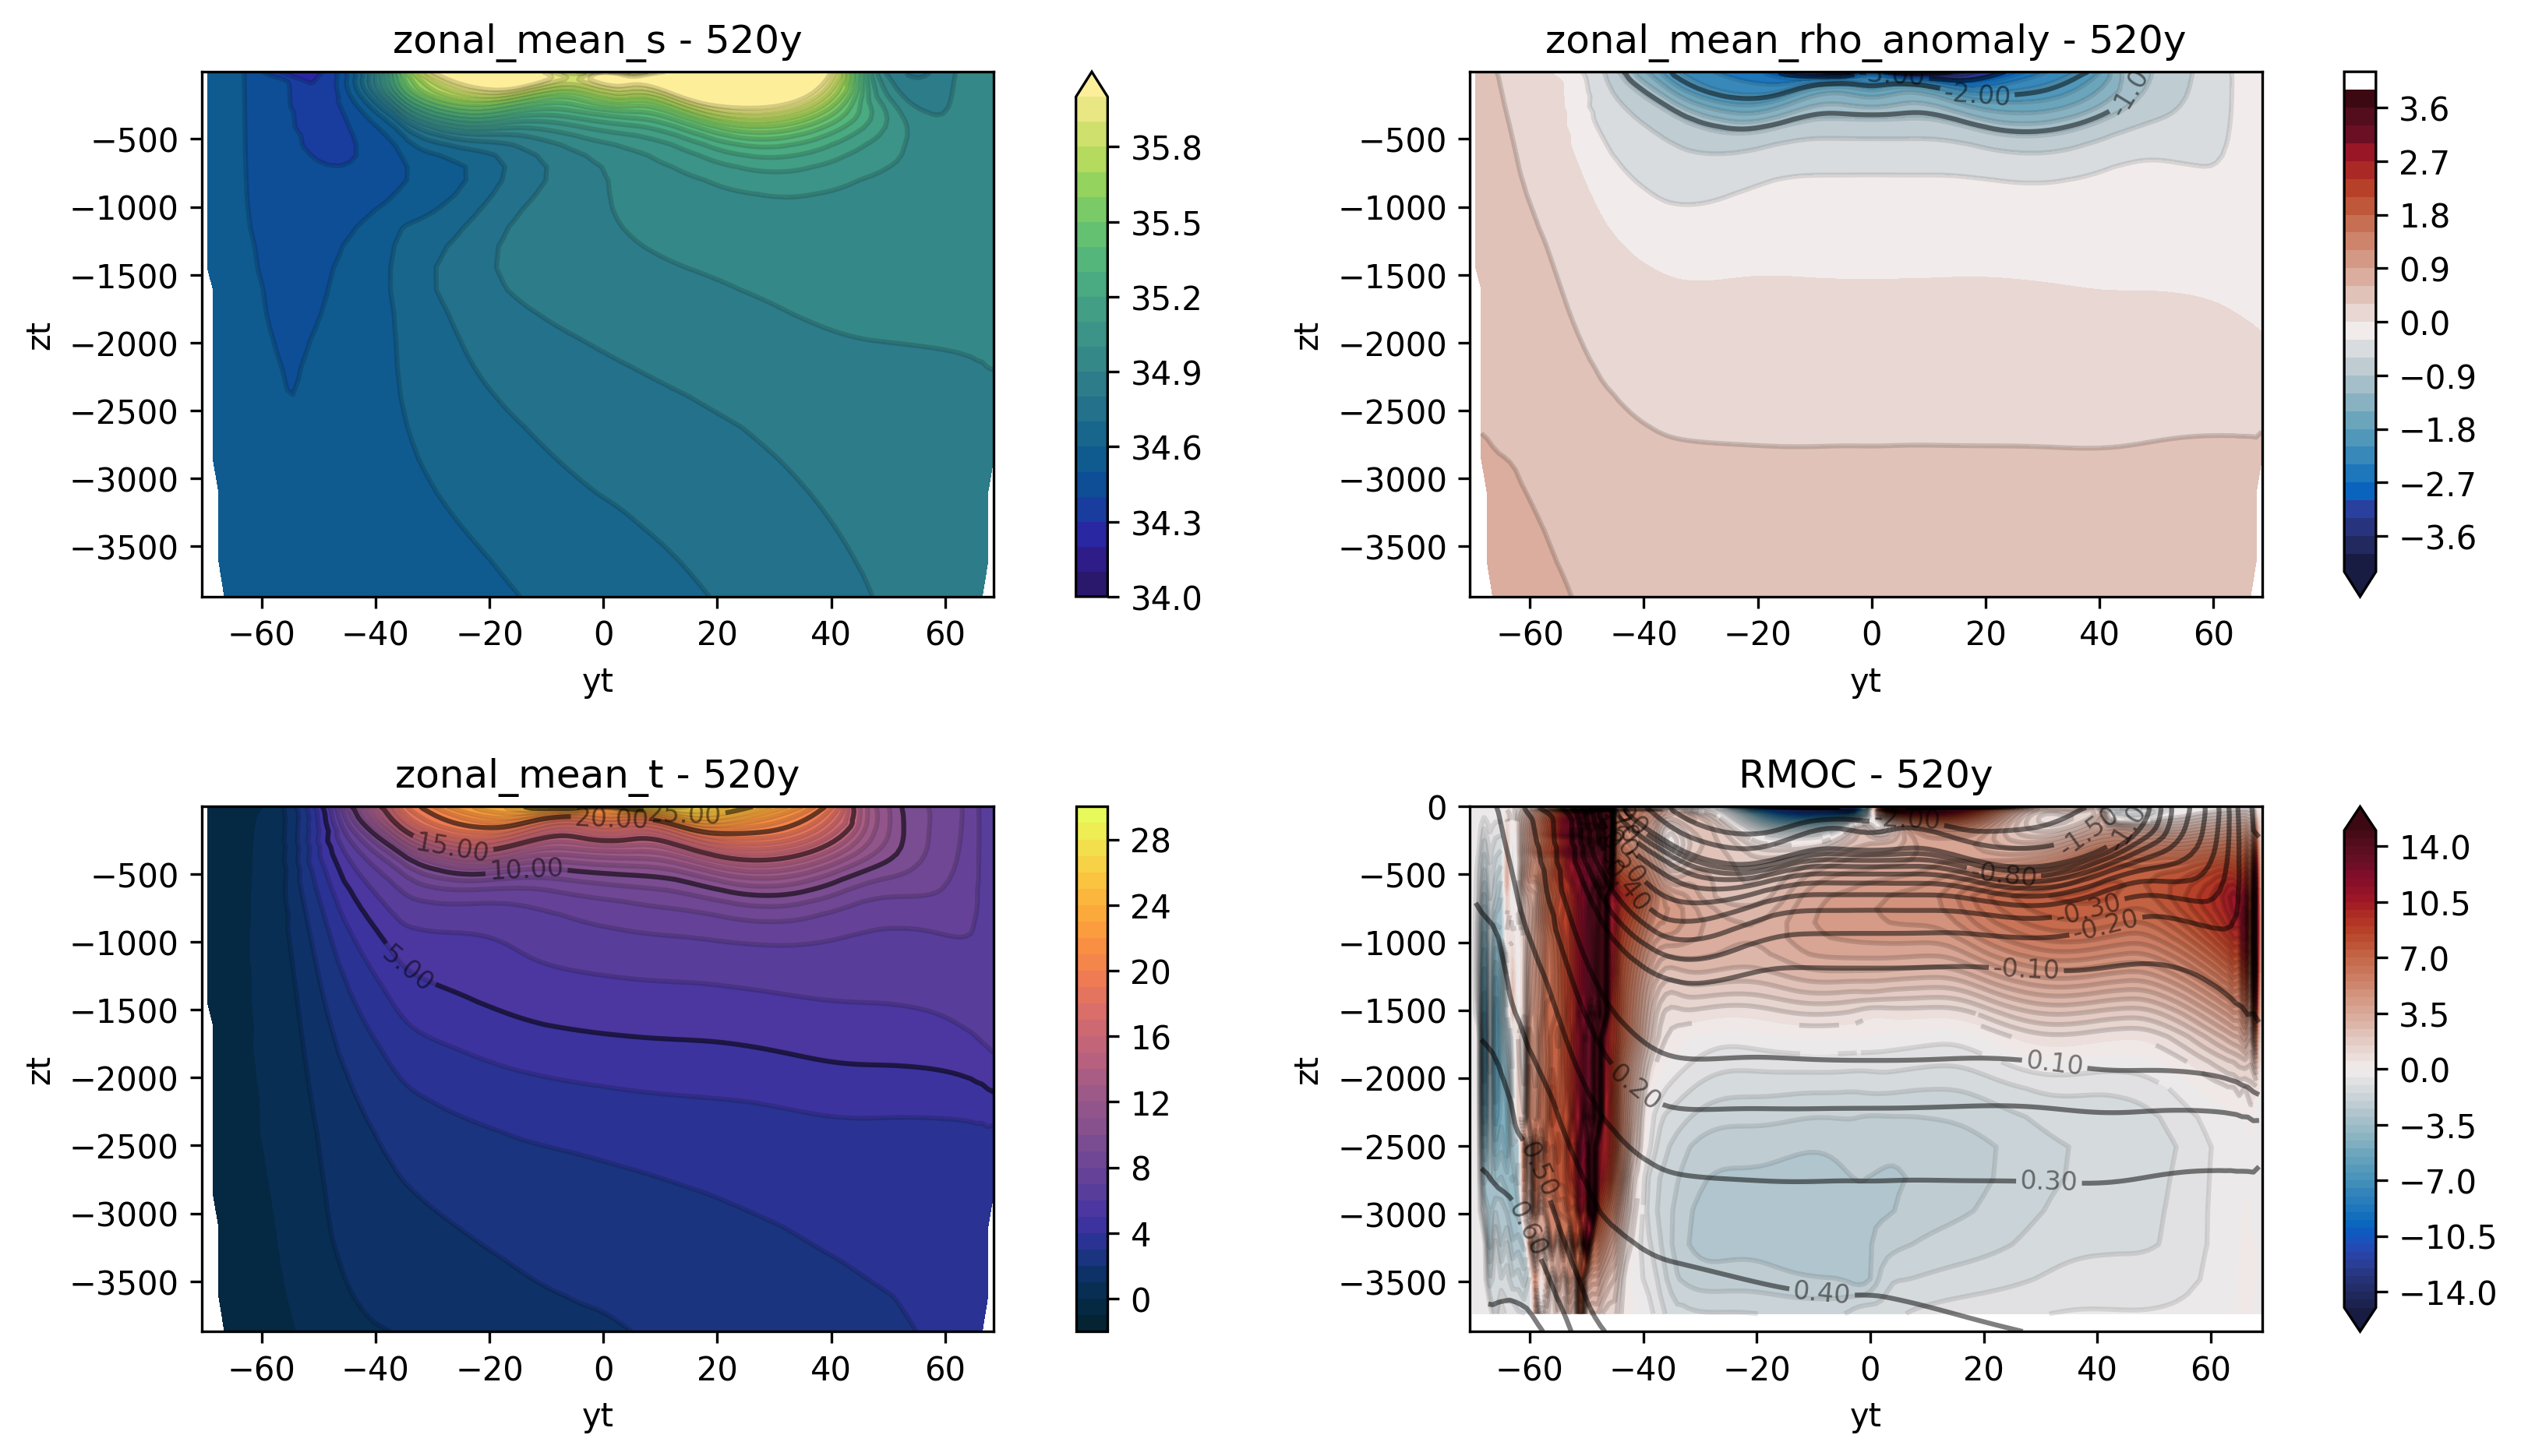

In [20]:
fig = plt.figure(figsize=(12,7), dpi=300)

gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.4)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0], width_ratios=[1, 0.04], hspace = 0.4)

ax1 = fig.add_subplot(gs00[0])
cax1 = fig.add_subplot(gs00[1])
ax1_labeled_levels = [34.0, 34.5, 35., 35.5, 36., 36.5, 37.]
ax1_labeled_levels = np.arange(0,25,0.5)
contour1 = axis_depth_long_two_fields(ax1, "zonal_mean_s", dict_field_zonal_mean_s, dict_field_zonal_mean_s, span = (34,36), norm='Normalize', levels = 21, labeled_levels = ax1_labeled_levels, alpha_lines=0.25 , cmap = "cmo.haline", neg_pos = False)
fig.colorbar(contour1, cax=cax1, orientation='vertical')
#cax_t.set_title(field)

ax2 = fig.add_subplot(gs00[2])
cax2 = fig.add_subplot(gs00[3])
contour2 = axis_depth_long_two_fields(ax2, "zonal_mean_t", dict_field_zonal_mean_t, dict_field_zonal_mean_t, span = (-2, 30), norm='Normalize', levels = 33, labeled_levels = [0., 5., 10., 15., 20., 25., 30.], cmap="cmo.thermal")
fig.colorbar(contour2, cax=cax2, orientation='vertical')

gs01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[1], width_ratios=[1, 0.04], hspace = 0.4)

ax3 = fig.add_subplot(gs01[0])
cax3 = fig.add_subplot(gs01[1])
contour3 = axis_depth_long_two_fields(ax3, "zonal_mean_rho_anomaly", dict_field_zonal_mean_rho_anomaly, dict_field_zonal_mean_rho_anomaly, span = (-4,4), norm='Normalize', levels = 31, labeled_levels = [-4., -3, -2., -1, 0., 1, 2., 3., 4.], cmap="cmo.balance")
fig.colorbar(contour3, cax=cax3, orientation='vertical')


ax4 = fig.add_subplot(gs01[2])
cax4 = fig.add_subplot(gs01[3])
contour4 = axis_depth_long_two_fields(ax4, "RMOC", dict_field_rmoc, dict_field_zonal_mean_rho_anomaly, span = (-15,15), levels = 61, labeled_levels = labeled_lines_rho)
fig.colorbar(contour4, cax=cax4, orientation='vertical')

#plt.tight_layout()
plt.show()

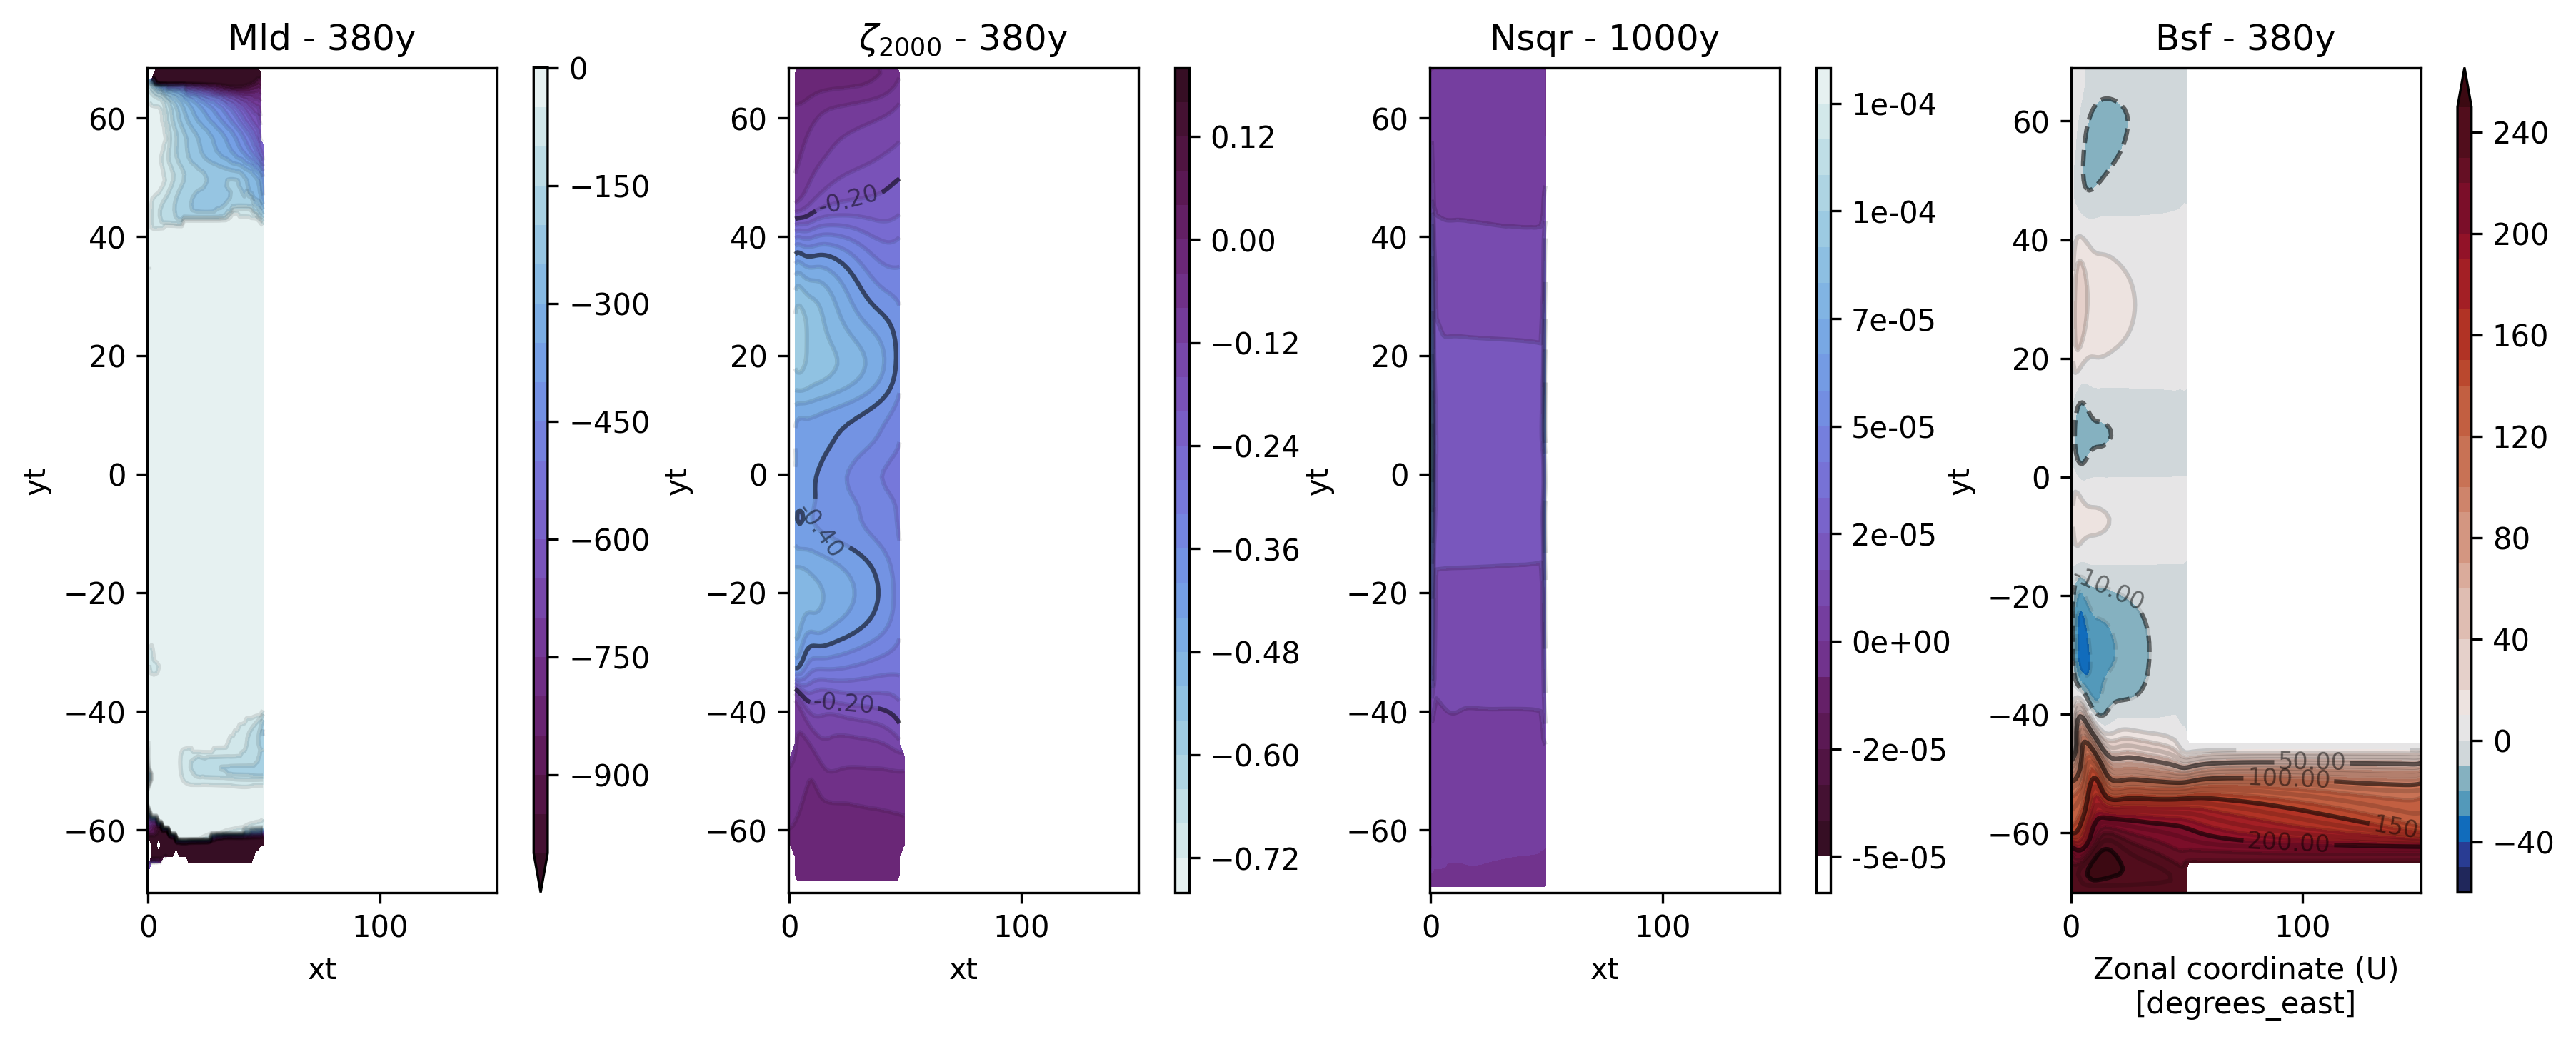

In [24]:
fig = plt.figure(figsize=(14,5), dpi=300)

gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.6)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[1, 0.04], hspace = 0.4)
ax1 = fig.add_subplot(gs1[0])
cax1 = fig.add_subplot(gs1[1])
contour1 = axis_depth_long_two_fields(ax1, 'Mld', dict_field_mld, dict_field_mld, span=(-1000, 0), norm='Normalize', levels = 21, cmap = "cmo.dense_r")
fig.colorbar(contour1, cax=cax1, orientation='vertical')
#cax_t.set_title(field)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=[1, 0.04], hspace = 0.4)
ax2 = fig.add_subplot(gs2[0])
cax2 = fig.add_subplot(gs2[1])
contour2 = axis_depth_long_two_fields(ax2, r'$\zeta_{2000}$', dict_field_zeta_2000, dict_field_zeta_2000, span=(-0.75, 0.2), norm='Normalize', levels = 31, labeled_levels = [0.,-0.2, -0.4, -0.6, -0.8, -1, -1.25, 1.5], cmap = "cmo.dense")
fig.colorbar(contour2, cax=cax2, orientation='vertical')

gs3 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2], width_ratios=[1, 0.04], hspace = 0.4)
ax3 = fig.add_subplot(gs3[0])
cax3 = fig.add_subplot(gs3[1])
contour3 = axis_depth_long_two_fields(ax3, 'Nsqr', dict_field_Nsqr, dict_field_Nsqr, (-5e-5, 1.25e-4), norm='Normalize', levels = 25, labeled_levels = [-10], cmap = "cmo.dense_r")
fig.colorbar(contour3, cax=cax3, orientation='vertical', format='%.0e')

gs4 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[3], width_ratios=[1, 0.04], hspace = 0.4)
ax4 = fig.add_subplot(gs4[0])
cax4 = fig.add_subplot(gs4[1])
contour4 = axis_depth_long_two_fields(ax4, 'Bsf', dict_field_bsf, dict_field_bsf, span=(-60, 250), norm='TwoSlopeNorm', levels = 32, labeled_levels = [-10, 50, 100, 150, 200, 250], cmap = "cmo.balance", neg_pos = True)
fig.colorbar(contour4, cax=cax4, orientation='vertical')

ax3.set_ylabel(r'yt')
ax4.set_ylabel(r'yt')

#ax1.set_xlim(0,60), ax2.set_xlim(0,60), ax3.set_xlim(0,60), ax4.set_xlim(0,60)


#plt.tight_layout()
plt.show()

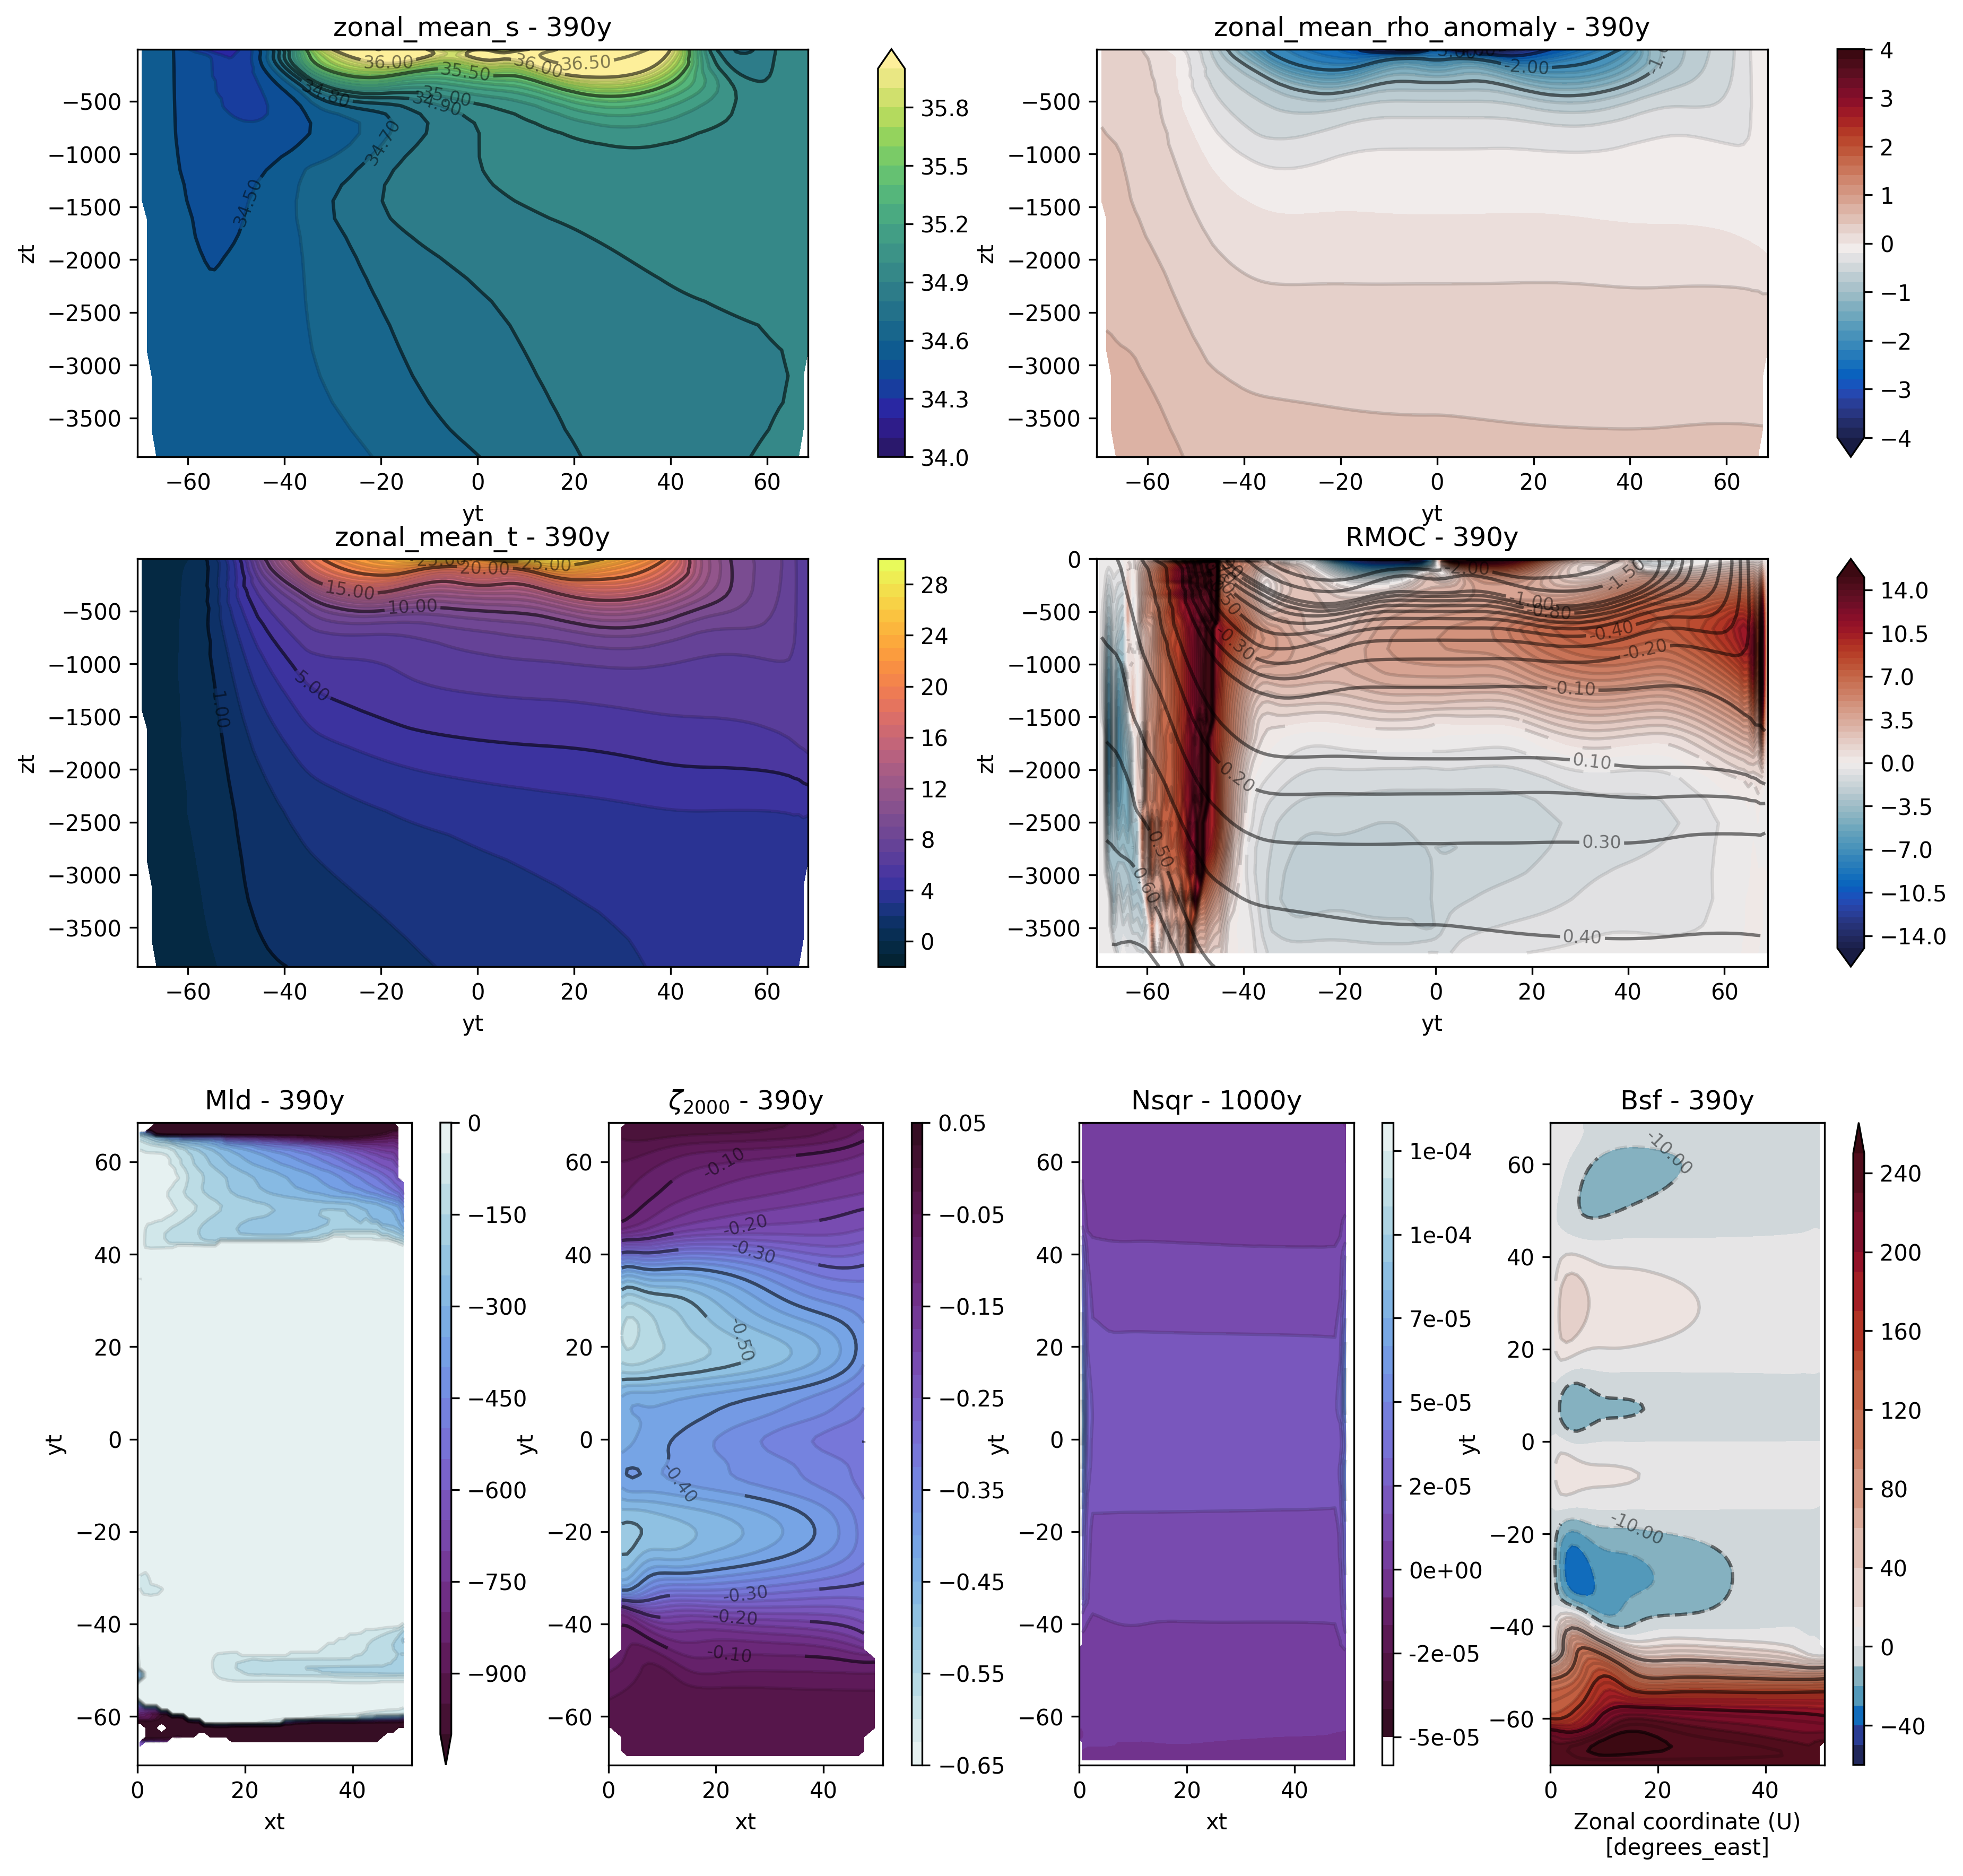

In [22]:
fig = plt.figure(figsize=(14,14), dpi=300)

gs0 = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 1], height_ratios=[2, 1.4],  wspace=0.25)
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0,0], width_ratios=[1, 0.04], hspace = 0.25)


ax1 = fig.add_subplot(gs00[0])
cax1 = fig.add_subplot(gs00[1])
contour1 = axis_depth_long_two_fields(ax1, "zonal_mean_s", dict_field_zonal_mean_s, dict_field_zonal_mean_s, span = (34,36), norm='Normalize', levels = 21, labeled_levels = [34.0, 34.5, 34.7, 34.8, 34.9, 35., 35.5, 36., 36.5, 37.], cmap = "cmo.haline", neg_pos = False)
fig.colorbar(contour1, cax=cax1, orientation='vertical')

#cax_t.set_title(field)

ax2 = fig.add_subplot(gs00[2])
cax2 = fig.add_subplot(gs00[3])
contour2 = axis_depth_long_two_fields(ax2, "zonal_mean_t", dict_field_zonal_mean_t, dict_field_zonal_mean_t, span = (-2, 30), norm='Normalize', levels = 33, labeled_levels = [-1, 0., 1., 5., 10., 15., 20., 25., 30.], cmap="cmo.thermal")
fig.colorbar(contour2, cax=cax2, orientation='vertical')

gs01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0,1], width_ratios=[1, 0.04], hspace = 0.25)


ax3 = fig.add_subplot(gs01[0])
cax3 = fig.add_subplot(gs01[1])
contour3 = axis_depth_long_two_fields(ax3, "zonal_mean_rho_anomaly", dict_field_zonal_mean_rho_anomaly, dict_field_zonal_mean_rho_anomaly, span = (-4,4), norm='Normalize', levels = 41, labeled_levels = [-4., -3, -2., -1, 0., 1, 2., 3., 4.], cmap="cmo.balance")
fig.colorbar(contour3, cax=cax3, orientation='vertical')
    
#H_thin_contour = H_thin_4000.sel(yt=slice(None, None)).plot(ax=ax3, color='tab:orange', linewidth=1.5, label=r'$H_{thin}$')
# H_mld = dict_field_mld.weighted(weight_surf).mean(dim=('xt'))
# H_mld_contour = H_mld.plot(ax=ax3, color='tab:purple', linewidth=1.5, label=r'$H_{MLD}$')

ax4 = fig.add_subplot(gs01[2])
cax4 = fig.add_subplot(gs01[3])
contour4 = axis_depth_long_two_fields(ax4, "RMOC", dict_field_rmoc, dict_field_zonal_mean_rho_anomaly, span = (-15,15), levels = 61, labeled_levels = labeled_lines_rho)

#H_thin_contour = H_thin_4000.sel(yt=slice(None, None)).plot(ax=ax4, color='tab:orange', linewidth=1.5, label=r'$H_{thin}$')

fig.colorbar(contour4, cax=cax4, orientation='vertical')



gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[1,:], width_ratios=[1, 1, 1, 1], wspace = 0.5)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[1, 0.04])
axb1 = fig.add_subplot(gs1[0])
caxb1 = fig.add_subplot(gs1[1])
contourb1 = axis_depth_long_two_fields(axb1, 'Mld', dict_field_mld, dict_field_mld, span=(-1000, 0), norm='Normalize', levels = 21, cmap = "cmo.dense_r")
fig.colorbar(contourb1, cax=caxb1, orientation='vertical')
#cax_t.set_title(field)
axb1.set_xlim(0,51)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=[1, 0.04])
axb2 = fig.add_subplot(gs2[0])
caxb2 = fig.add_subplot(gs2[1])
contourb2 = axis_depth_long_two_fields(axb2, r'$\zeta_{2000}$', dict_field_zeta_2000, dict_field_zeta_2000, span=(-0.65, 0.05), norm='Normalize', levels = 29, labeled_levels = [0., -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.8,], cmap = "cmo.dense")
fig.colorbar(contourb2, cax=caxb2, orientation='vertical', ticks=[0.05, -0.05, -0.15, -0.25, -0.35, -0.45, -0.55, -0.65])
axb2.set_xlim(0,51)

gs3 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2], width_ratios=[1, 0.04])
axb3 = fig.add_subplot(gs3[0])
caxb3 = fig.add_subplot(gs3[1])
contourb3 = axis_depth_long_two_fields(axb3, 'Nsqr', dict_field_Nsqr, dict_field_Nsqr, (-5e-5, 1.25e-4), norm='Normalize', levels = 25, labeled_levels = [-10], cmap = "cmo.dense_r")
fig.colorbar(contourb3, cax=caxb3, orientation='vertical', format='%.0e')
axb3.set_xlim(0,51)

gs4 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[3], width_ratios=[1, 0.04])
axb4 = fig.add_subplot(gs4[0])
caxb4 = fig.add_subplot(gs4[1])
contourb4 = axis_depth_long_two_fields(axb4, 'Bsf', dict_field_bsf, dict_field_bsf, span=(-60, 250), norm='TwoSlopeNorm', levels = 32, labeled_levels = [-10, 50, 100, 150, 200, 250], cmap = "cmo.balance", neg_pos = True)
fig.colorbar(contourb4, cax=caxb4, orientation='vertical')
axb4.set_xlim(0,51)

axb3.set_ylabel(r'yt')
axb4.set_ylabel(r'yt')

#plt.tight_layout()
path_to_plot = f"/home/x_titmo/work/analysis/NeverWorld2/plots/clim/"
#plt.savefig(path_to_plot + f'Clim_480.png', bbox_inches='tight')
plt.show()


In [23]:
# Compute MOC from .averages file

v = ds_avg.v.where(ds_snap.xt<50.)  # Meridional velocity (y-direction)
dzt = ds_snap.dzt # Vertical grid spacing
dxt = ds_snap.dxt # Zonal grid spacing
aera_v = ds_snap.area_v # Ocean mask
dyu = ds_snap.dyu
# Compute zonally integrated transport
#zonal_transport = (v * ds_snap.dzt *  ds_snap.dxt * ds_snap.area_v ).sum(dim='xt') 
zonal_transport = (v * ds_snap.area_v / dyu).sum(dim='xt') #= v * cosu * dxt (* dyu )

moc_streamfunction_computed = (zonal_transport * ds_snap.dzt).cumsum(dim='zt')
moc_streamfunction_computed = -moc_streamfunction_computed.isel(Time=-1) * 1e-6
# Extract MOC from .overturning file
moc_streamfunction_extracted = -ds_ovr.isel(Time=-1).vsf_depth * 1e-6


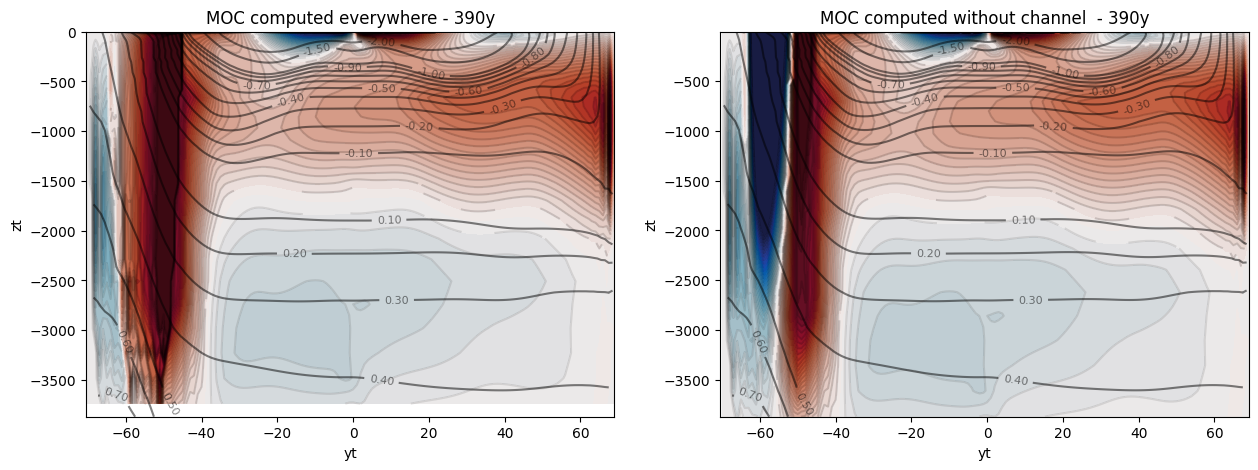

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axis_depth_long_two_fields(axs[0], "MOC computed everywhere", moc_streamfunction_extracted, dict_field_zonal_mean_rho_anomaly, span = (-15,15), levels = 61, labeled_levels = labeled_lines_rho)
axis_depth_long_two_fields(axs[1], "MOC computed without channel ", moc_streamfunction_computed, dict_field_zonal_mean_rho_anomaly, span = (-15,15), levels = 61, labeled_levels = labeled_lines_rho)

In [94]:
salt = ds_avg.salt.sel(Time=ytp * 365, method="nearest").where(ds_avg.xt<50.)
temp = ds_avg.temp.sel(Time=ytp * 365, method="nearest").where(ds_avg.xt<50.)
zt=ds_snap.zt
zw=ds_snap.zw

dct_dzt = temp.diff('zt') / dzt.isel(zt=slice(1,None))
dsa_dzt = salt.diff('zt') / dzt.isel(zt=slice(1,None))
first_value_dct_dzt = dct_dzt.isel(zt=0).expand_dims(dim='zt', axis=0)
first_value_dsa_dzt = dsa_dzt.isel(zt=0).expand_dims(dim='zt', axis=0)
dct_dzt = xr.concat([first_value_dct_dzt, dct_dzt], dim='zt')
dsa_dzt = xr.concat([first_value_dsa_dzt, dsa_dzt], dim='zt')

dct_dzw = xr.DataArray(dct_dzt.values, dims=('zw', 'yt', 'xt'), coords={'zw': zw, 'yt': temp.yt, 'xt': temp.xt})
dsa_dzw = xr.DataArray(dsa_dzt.values, dims=('zw', 'yt', 'xt'), coords={'zw': zw, 'yt': temp.yt, 'xt': temp.xt})
drho_dct = neq2.nonlin2_eq_of_state_drhodT(temp, -zt)
drho_dsa = neq2.nonlin2_eq_of_state_drhodS()

dz_dsigma =1/(drho_dct*dct_dzw.values + drho_dsa*dsa_dzw.values)

In [100]:
v = ds_avg.v.isel(Time=-1)
aera_v = ds_snap.area_v
zonal_transport_z = (v * aera_v).sum(dim='xt')  # m³/s per dz
zonal_transport_sigma = zonal_transport_z.values[:,:, np.newaxis] * dz_dsigma


In [25]:
def compute_histo_time_i(ds_snap, time_i=-1, which_one='euler'):
    ## REF
    # Sp1 = np.hstack([np.arange(0, 28, 2),np.arange(28, 32.5, .1),np.arange(32.5, 33.5, .025),np.arange(33.5, 34, .01),35,40])
    ## Clim
    Sp1 = np.hstack([np.arange(0, 28, 2),np.arange(28, 32., .05),np.arange(32., 33.1, .025),np.arange(33.1, 34.1, .01), np.arange(34.1, 34.4, .005),35,40])
    
    S_bins   = (Sp1[1:]+Sp1[:-1])/2

    sigma2 = neq2.nonlin2_eq_of_state_rho(ds_snap.salt.isel(Time= time_i), ds_snap.temp.isel(Time= time_i), p=2000.0)
    sigma2_reshaped = sigma2.transpose("xt", "zt", "yt").values.reshape(52 * 36, len(ds_snap.yt)).T  # Shape (zt, xt * yt)
    print(sigma2.max().values)
    if which_one == 'euler' : 
        w = ds_snap.w.isel(Time= time_i).transpose("xt", "yt", "zw")
        weights_np = zonal_transport_sigma.fillna(0).transpose("xt", "zt", "yt").values 

    weights_np = weights_np.reshape(52 * 36, len(ds_snap.yt)).T  # Shape (zt, xt * yt)
    
    stacked_data = np.hstack((sigma2_reshaped, weights_np))
    print(stacked_data.shape)
    print(sigma2_reshaped.shape[1])
    # histogram_i = np.apply_along_axis(
    #     lambda x: np.histogram(x[:sigma2_reshaped.shape[1]], bins=Sp1, weights=x[sigma2_reshaped.shape[1]:])[0],
    #     axis=1, 
    #     arr=stacked_data
    #     )

    histogram_i = np.zeros((len(ds_snap.yt), len(Sp1) - 1))  # Preallocate histogram array
    for i in range(len(ds_snap.yt)):
        hist_i, _ = np.histogram(sigma2_reshaped[i, :], bins=Sp1, weights= weights_np[i, :])   
        histogram_i[i, :] = hist_i
    return S_bins, histogram_i

In [26]:
S_bins, histogram_euler = compute_histo_time_i(ds_snap, time_i=-1, which_one='euler')
histogram_xr_euler = xr.DataArray(histogram_euler, dims=('yt', 'sigma2'), coords={'yt': ds_snap.yt, 'sigma2': S_bins})

ValueError: cannot reshape array of size 766080 into shape (1872,140)

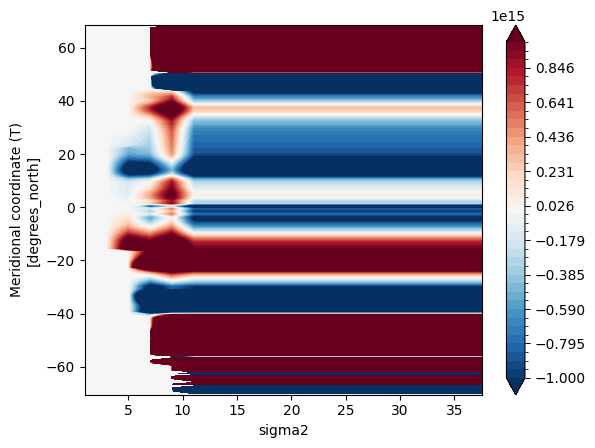

In [ ]:
histogram_xr_euler.cumsum('sigma2').plot.contourf(levels=40, vmax=1e15)

In [76]:
PI = 3.14159265358979323846264338327950588

tau_x = ds_snap.surface_taux.transpose("xu", "yt").fillna(0).values  # Zonal wind stress (N/m²)
tau_y = ds_snap.surface_tauy.transpose("xt", "yu").fillna(0).values  # Meridional wind stress (N/m²)
cosu = np.cos(ds_snap.yu * PI / 180.0).values
cost = np.cos(ds_snap.yt * PI / 180.0).values
dxt = ds_snap.dxt.values
dyt = ds_snap.dyt.values

dzt = ds_snap.dzt

f_coriolis = 2 * PI / 43082.0 * np.sin(ds_snap.yu / 180.0 * PI)  # Coriolis parameter at tracer points


wind_stress_curl = np.zeros_like(ds_avg.w.isel(Time=-1).transpose("xt", "yt", "zw").fillna(0).values)

wind_stress_curl[1:, 1:, :] = (1
    * ((tau_y[1:, 1:, np.newaxis] - tau_y[:-1, 1:, np.newaxis])
        / (cost[np.newaxis, 1:, np.newaxis] * dxt[1:, np.newaxis, np.newaxis])

        - (cosu[np.newaxis, 1:, np.newaxis] * tau_x[1:, 1:, np.newaxis]
            - cosu[np.newaxis, :-1, np.newaxis] * tau_x[1:, :-1, np.newaxis])
         / (cost[np.newaxis, 1:, np.newaxis] * dyt[np.newaxis, 1:, np.newaxis])
    ))
wind_stress_curl = xr.DataArray(wind_stress_curl, dims=('xu', 'yu', 'zt'), coords={'xu': ds_snap.xu, 'yu': ds_snap.yu, 'zt': ds_snap.zt})

# Compute Ekman pumping velocity (m/s)
w_E = wind_stress_curl / (1024 * f_coriolis)


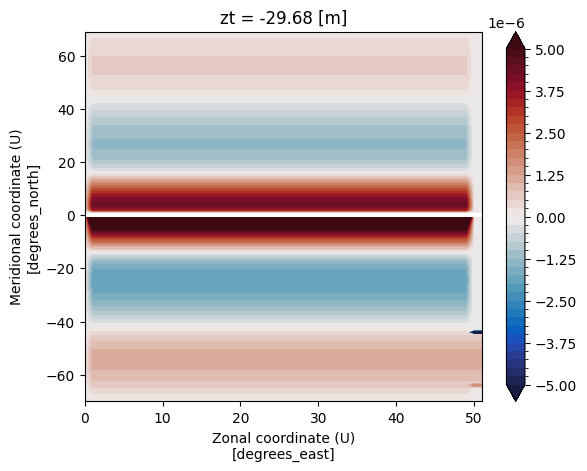

In [77]:
w_E.isel(zt=-3).plot.contourf(x='xu', vmax=5e-6, levels=41, cmap='cmo.balance')
#plt.ylim(-50, -40)

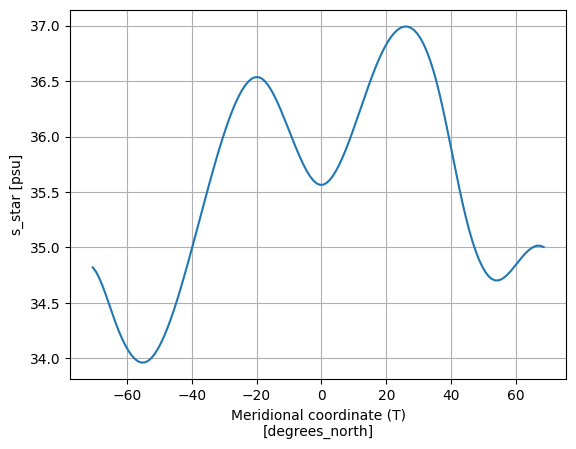

In [35]:
ds_snap.s_star.plot()
plt.grid()

In [105]:
sigma2 = neq2.nonlin2_eq_of_state_rho(salinity, temperature, 2000)

In [134]:
Sp1 = np.hstack([np.arange(0, 28, 2),np.arange(28, 32.5, .1),np.arange(32.5, 33.5, .025),np.arange(33.5, 34, .01),35,40])
print(len(Sp1))

Sp1 = np.hstack([np.arange(0, 28, 2),np.arange(28, 32., .05),np.arange(32., 33.1, .025),np.arange(33.1, 34.1, .01), np.arange(34.1, 34.4, .005),35,40])
Sp1 = np.arange(10,37, 0.5)

151


(0.0, 40.0)

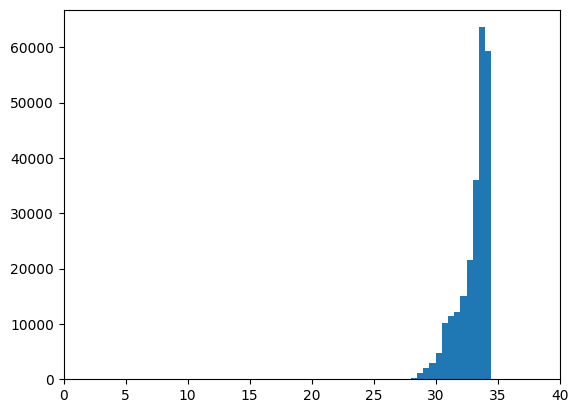

In [136]:
plt.hist(24.+sigma2.values.flatten(), Sp1)
plt.xlim(0,40)